# Electrisity Output and Wind Speed Model

## SRIMAX

### Data Loading and Checking

             DATETIME  CF  WS_1133733  WS_1156770  WS_1156968  WS_1182195  \
0 2020-01-09 00:00:00 NaN        1.69        1.88        3.15        0.92   
1 2020-01-09 01:00:00 NaN        1.60        2.02        3.91        0.44   
2 2020-01-09 02:00:00 NaN        1.79        2.14        4.20        0.65   
3 2020-01-09 03:00:00 NaN        2.01        2.32        5.17        0.51   
4 2020-01-09 04:00:00 NaN        2.12        2.54        4.19        0.77   

   WS_1193865  WS_1321569  WS_1324653  WS_1358699  ...  WS_78208  WS_811655  \
0        2.27        1.14        1.24        2.98  ...      1.40       1.27   
1        2.36        1.15        1.63        2.83  ...      1.02       1.11   
2        2.06        1.28        2.36        3.07  ...      1.39       1.42   
3        2.31        0.83        3.39        3.38  ...      1.55       2.01   
4        4.52        0.97        2.89        3.79  ...      1.64       2.40   

   WS_839753  WS_875373  WS_883683  WS_883699  WS_914573  WS_9

<AxesSubplot:xlabel='DATETIME'>

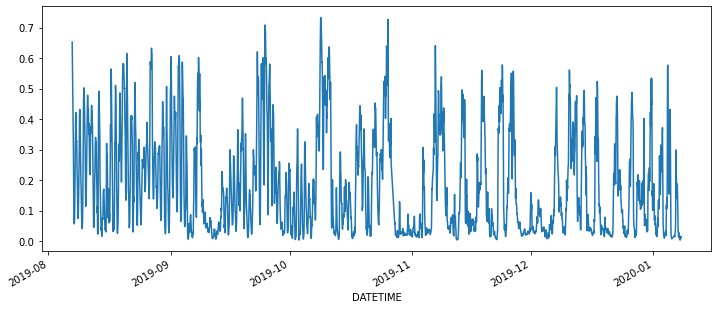

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import statsmodels.api as sm
from tqdm import tqdm

## Data Analysis: It looks this data is stationary.No obvious upward/doward trend or seasonality.
df = pd.read_excel('Wind_data.xlsx', sheet_name=[0, 1])
df_train, df_test = df.get(0), df.get(1)

print(df_test.head())
print(df_test.info())
print(df_test.describe())
print(df_train.isnull().values.any())
print(df_test.isnull().any(axis=1).sum())
print(df_test.isnull().any(axis=0).sum())
df_train = df_train.dropna()
print(f'Data Dim: {df_train.shape}')
dfp = pd.read_excel('Wind_data.xlsx', index_col='DATETIME', sheet_name=[0, 1])
dfp.get(0)['CF'].plot(figsize=(12,5))

/Users/steven/opt/anaconda3/lib/python3.9/site-packages/matplotlib/axes/_base.py:2475: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/Users/steven/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/Users/steven/opt/anaconda3/lib/python3.9/site-packages/matplotlib/axes/_base.py:2475: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


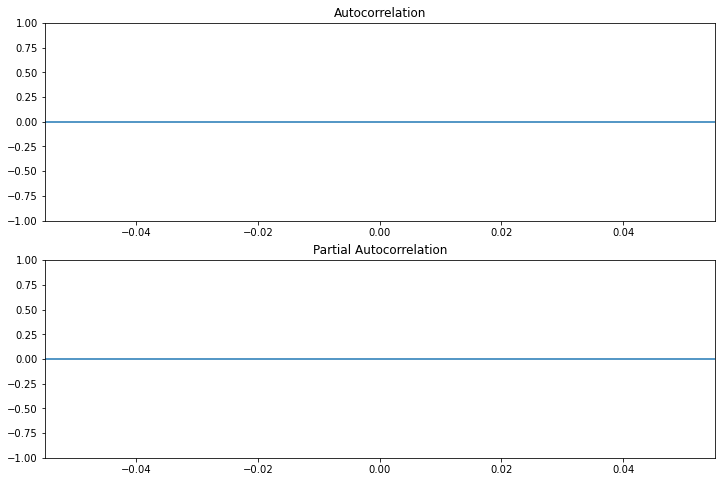

/Users/steven/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/Users/steven/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/steven/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


,d,adf_stats,p-value,is_adf_stationary,is_kpss_stationary,is_stationary
0,0,4.289205e-14,0.01,True,False,False
1,1,4.822957e-24,0.10,True,True,True
2,2,0.000000e+00,0.10,True,True,True


In [4]:
# The ACF and PACF plot shows that the present value of the series is related with its past value.
## The obtain_adf_kpss_rsults show that the difference parameter d=1 is a proper choise

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss


# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
 
# Plot the ACF of df_store_2_item_28_timeon ax1
plot_acf(df_train['CF'].diff(),lags=14, zero=False, ax=ax1)

# Plot the PACF of df_store_2_item_28_timeon ax2
plot_pacf(df_train['CF'].diff(),lags=14, zero=False, ax=ax2)

plt.show()

def obtain_adf_kpss_results(timeseries, max_d):
    """ Build dataframe with ADF statistics and p-value for time series after applying difference on time series
    
    Args:
        time_series (df): Dataframe of univariate time series  
        max_d (int): Max value of how many times apply difference
        
    Returns:
        Dataframe showing values of ADF statistics and p when applying ADF test after applying d times 
        differencing on a time-series.
    
    """
    
    results=[]

    for idx in range(max_d):
        adf_result = adfuller(timeseries, autolag='AIC')
        kpss_result = kpss(timeseries, regression='c', nlags="auto")
        timeseries = timeseries.diff().dropna()
        if adf_result[1] <=0.05:
            adf_stationary = True
        else:
            adf_stationary = False
        if kpss_result[1] <=0.05:
            kpss_stationary = False
        else:
            kpss_stationary = True
            
        stationary = adf_stationary & kpss_stationary
            
        results.append((idx,adf_result[1], kpss_result[1],adf_stationary,kpss_stationary, stationary))
    
    # Construct DataFrame 
    results_df = pd.DataFrame(results, columns=['d','adf_stats','p-value', 'is_adf_stationary','is_kpss_stationary','is_stationary' ])
    
    return results_df


def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)


def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
    
obtain_adf_kpss_results(df_train['CF'],3)

# print(f'The above table indicates d == 1 is a good choice')

#### The above table indicates d==1 is a good choice

### Feature Engineering: Identify significant variables

<AxesSubplot:>

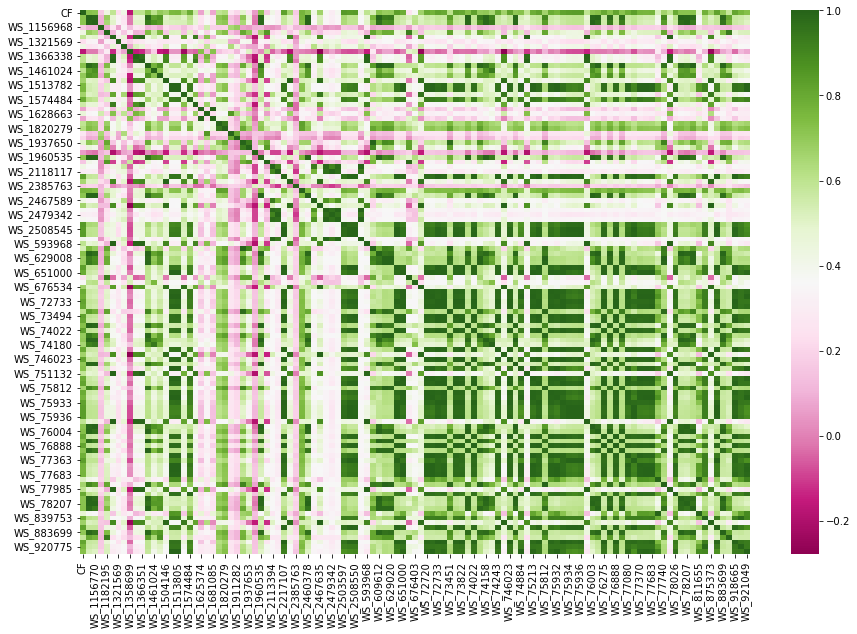

In [5]:
# Compute correlation between variables and target
# In this correlation map, light color means lower covariance of two variables.
# We can not manually decide which features are salent, it looks like most of the features are relavant. 
# As a result, some numeriacal feature selection algorithms can be adopted.

import seaborn as sns
data = df_train
data.corr(method='pearson')
plt.subplots(figsize=(15, 10))
sns.heatmap(data.corr(), cmap="PiYG")

### Data Preprocessing

In [6]:
# I found It's useful to add hours as a feature which decreases MAE by 0.01 on validation dataset.
def pre_process(data,drop_time=False):
  
    data['hour'] = data['DATETIME'].dt.hour
    data['month'] = data['DATETIME'].dt.month
    data['day'] = data['DATETIME'].dt.day
    if not drop_time:
        data = data.set_index('DATETIME')
    else:
        data = data.drop(['DATETIME'], axis=1)   
    
    return(data)

In [7]:
data = pre_process(df_train,drop_time=True)

print(data.head())

         CF  WS_1133733  WS_1156770  WS_1156968  WS_1182195  WS_1193865  \
0  0.652524       10.35        8.99        4.57        9.69        8.90   
1  0.605852        9.70        8.28        5.78        9.10        7.98   
2  0.564094        9.04        7.39        6.21        8.98        7.78   
3  0.532721        8.78        7.49        6.43        8.84        7.82   
4  0.495608        8.23        6.88        6.81        8.52        6.65   

   WS_1321569  WS_1324653  WS_1358699  WS_1366338  ...  WS_875373  WS_883683  \
0        2.90        5.74        1.16        8.81  ...      11.63      10.72   
1        2.23        3.46        0.97        7.75  ...      11.10      11.02   
2        1.98        2.62        0.92        7.55  ...      10.74      11.19   
3        1.33        2.43        0.68        7.53  ...      10.65      11.27   
4        1.64        2.45        0.59        6.40  ...       9.78      10.85   

   WS_883699  WS_914573  WS_918665  WS_920775  WS_921049  hour  mont

### data split

In [8]:
# shuffle data samples
# df_train = df_train.sample(frac = 1)

# split train and validation 
Y = data[['CF']]
X = data.drop(['CF'], axis=1)
X = sm.add_constant(X)
x_train, x_val,y_train, y_val = X[:-92], X[-92:], Y[:-92], Y[-92:]

print(x_train.shape)
print(y_train.shape)

(3543, 116)
(3543, 1)


### Model Training

#### Grid search to find the best model parameters

In [ ]:
def pre_process(data,drop_time=False):
  
    data['hour'] = data['DATETIME'].dt.hour
    data['month'] = data['DATETIME'].dt.month
    data['day'] = data['DATETIME'].dt.day
    if not drop_time:
        data = data.set_index('DATETIME')
    else:
        data = data.drop(['DATETIME'], axis=1)   
    
    return(data)



from statsmodels.tsa.statespace.sarimax import SARIMAX
res=[]

data_search = pre_process(df_train,drop_time=False)
print(data_search.head())

for p in range(7):
    for q in range(7):
        model = SARIMAX(data_search['CF'], order=(p,1,q),freq=data_search.index.inferred_freq) #because adf test showed that d=1
        output = model.fit()
        res.append((p,q,output.aic, output.bic))

res_sorted = pd.DataFrame(res, columns=['p','q','AIC','BIC'])

#### visualize grid search results


In [ ]:
# get the best (p,d,q) parameters for model training
res_sorted.sort_values('AIC').head()
res_sorted.sort_values('BIC').head()

#### Start Model Training

In [9]:
# Fit the model on total data
model_all = sm.tsa.statespace.SARIMAX(Y, exog=X, order=(1,0,1))
model_fit_all = model_all.fit(disp=False)
print(model_fit_all.summary())

/Users/steven/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                     CF   No. Observations:                 3635
Model:               SARIMAX(1, 0, 1)   Log Likelihood                7552.966
Date:                Fri, 08 Sep 2023   AIC                         -14867.932
Time:                        17:57:04   BIC                         -14130.327
Sample:                             0   HQIC                        -14605.196
                               - 3635                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1115      0.013     -8.412      0.000      -0.138      -0.086
WS_1133733    -0.0370      0.015     -2.429      0.015      -0.067      -0.007
WS_1156770    -0.0416      0.006     -6.590      0.0

##### Prob(Q) = 0. < 0.05.  We should reject the null hypothesis that the residuals are uncorrelated so the residuals are correlated. Prob(JB) = 0.02 < 0.05. We reject the null hypothesis that the residuals are normally distributed. Therefore, the residuals are not normally distributed.

In [10]:
# Fit the model without including val data
model = sm.tsa.statespace.SARIMAX(y_train, exog=x_train, order=(1,0,1))
model_fit = model.fit(disp=False)
print(f'x_train shape:{x_train.shape}')
print(model_fit.summary())

/Users/steven/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


x_train shape:(3543, 116)
                               SARIMAX Results                                
Dep. Variable:                     CF   No. Observations:                 3543
Model:               SARIMAX(1, 0, 1)   Log Likelihood                7379.441
Date:                Fri, 08 Sep 2023   AIC                         -14520.883
Time:                        18:17:05   BIC                         -13786.328
Sample:                             0   HQIC                        -14258.892
                               - 3543                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1224      0.016     -7.766      0.000      -0.153      -0.092
WS_1133733    -0.0305      0.015     -1.980      0.048      -0.061      -0.000
WS_1156770    -0.0418     

### Validation

3543    0.039408
3544    0.041447
3545    0.006212
3546   -0.004856
3547   -0.015613
          ...   
3630   -0.053431
3631   -0.054823
3632   -0.044700
3633   -0.015594
3634   -0.036824
Name: predicted_mean, Length: 92, dtype: float64 92 92
validation data MAE from sklearn mae metrics: 0.042
validation data MAE: 0.042


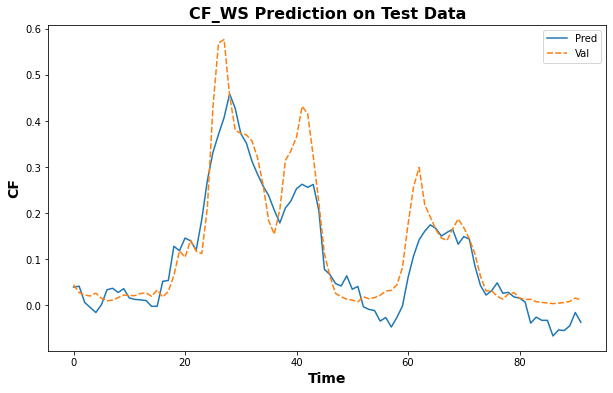

In [11]:
from sklearn.metrics import mean_absolute_error

# find first pred data sample
first_predict = x_val.iloc[0].name


forecast = model_fit.forecast(steps = len(x_val),exog = x_val)
print(forecast,len(forecast),len(x_val))

y_hat, y_validation = forecast.values, y_val.values
y_hat = y_hat.reshape(y_hat.shape[0], -1)

mae = mean_absolute_error(y_validation, y_hat)

#visualize predication 
## Prepare dataframe
results = np.concatenate((y_hat, y_validation), axis=1)
df_res = pd.DataFrame(results, columns=["Pred", "Val"]) 
## Set figure size
fig, ax = plt.subplots(figsize = (10,6))
## plot curve
sns.lineplot(data=df_res)
## Set title
ax.set_title('CF_WS Prediction on Test Data', fontdict={'fontsize':16, 'fontweight':'bold'})
## Set label for x-axis
ax.set_xlabel( "Time" , fontdict= { 'fontsize': 14, 'fontweight':'bold'})
## Set label for y-axis
ax.set_ylabel( "CF" , fontdict= { 'fontsize': 14, 'fontweight':'bold'})

# output MAE
print(f'validation data MAE from sklearn mae metrics: {np.mean(abs(y_hat - y_validation)):.3f}')
print(f'validation data MAE: {mae:.3f}')

### Process Test Data

In [12]:
data_test = pre_process(df_test,drop_time=True)
# data_test.drop(['CF'], axis=1)
data_test = pre_process(df_test,drop_time=True)
data_test.insert(loc=0, column='const', value = 1.0)
x_test = data_test.drop('CF', axis=1)
# sm.add_constant(x_test)
# x_test

0
(93, 116)
(93, 116)
3543   -0.000217
3544   -0.012743
3545   -0.007351
3546   -0.028869
3547    0.020898
          ...   
3631    0.003568
3632   -0.010514
3633    0.003734
3634   -0.014938
3635   -0.008571
Name: predicted_mean, Length: 93, dtype: float64 93 93


Text(0, 0.5, 'CF')

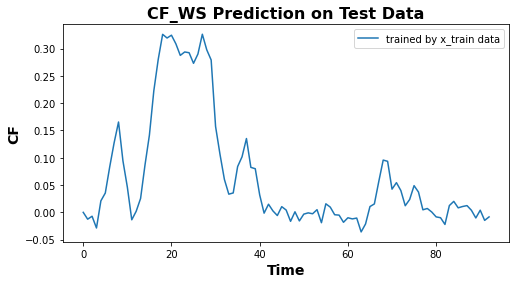

In [14]:
# last_train = train.iloc[len(train)-1].name
first_predict = x_test.iloc[0].name
print(first_predict)
print(x_test.shape)
x_test = (sm.add_constant(x_test).loc[first_predict:])
print(x_test.shape)

forecast = model_fit.forecast(steps = len(x_test),exog = x_test)
print(forecast,len(forecast),len(x_test))

y_hat = forecast.values
y_hat = y_hat.reshape(y_hat.shape[0], -1)


#visualize predication 
## Prepare dataframe
results = y_hat
# results = np.concatenate((y_hat), axis=1)
df_res = pd.DataFrame(results, columns=["trained by x_train data"]) 
## Set figure size
fig, ax = plt.subplots(figsize = (8,4))
# Plot the curve
sns.lineplot(data=df_res)
ax.set_title('CF_WS Prediction on Test Data', fontdict={'fontsize':16, 'fontweight':'bold'})
# Set label for x-axis
ax.set_xlabel( "Time" , fontdict= { 'fontsize': 14, 'fontweight':'bold'})
# Set label for y-axis
ax.set_ylabel( "CF" , fontdict= { 'fontsize': 14, 'fontweight':'bold'})

# output MAE
# print(f'validation data MAE from sklearn mae metrics: {np.mean(abs(y_hat - y_validation)):.3f}')
# print(f'validation data MAE: {mae:.3f}')

(93, 116)
3635    0.010474
3636    0.002339
3637    0.006448
3638   -0.010453
3639    0.033332
          ...   
3723    0.022084
3724    0.008958
3725    0.020348
3726    0.003364
3727    0.009575
Name: predicted_mean, Length: 93, dtype: float64 93


Text(0, 0.5, 'CF')

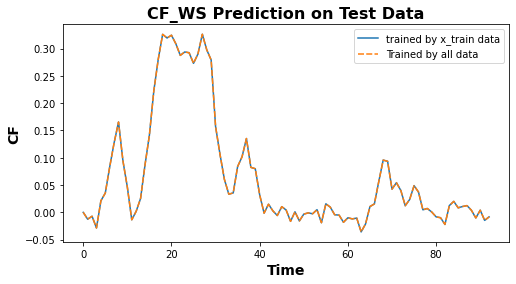

In [16]:
# last_train = train.iloc[len(train)-1].name
first_predict = x_test.iloc[0].name

x_test = (sm.add_constant(x_test).loc[first_predict:])
print(x_test.shape)

# predict with x_train model
forecast = model_fit.forecast(steps = len(x_test),exog = x_test)
# predict with all data model
forecast_all = model_fit_all.forecast(steps = len(x_test),exog = x_test)
# print(forecast,len(forecast),len(x_test))
print(forecast_all,len(forecast_all))


y_hat = forecast.values
y_hat = y_hat.reshape(y_hat.shape[0], -1)

y_hat_all = forecast_all.values
y_hat_all = y_hat.reshape(y_hat_all.shape[0], -1)
# mae = mean_absolute_error(y_validation, y_hat)

#visualize predication 
## Prepare dataframe
results = np.concatenate((y_hat, y_hat_all), axis=1)
df_res = pd.DataFrame(results, columns=["trained by x_train data", "Trained by all data"]) 
## Set figure size
fig, ax = plt.subplots(figsize = (8,4))
# Plot the curve
sns.lineplot(data=df_res)
ax.set_title('CF_WS Prediction on Test Data', fontdict={'fontsize':16, 'fontweight':'bold'})
# Set label for x-axis
ax.set_xlabel( "Time" , fontdict= { 'fontsize': 14, 'fontweight':'bold'})
# Set label for y-axis
ax.set_ylabel( "CF" , fontdict= { 'fontsize': 14, 'fontweight':'bold'})

## Diagnostics Analysis

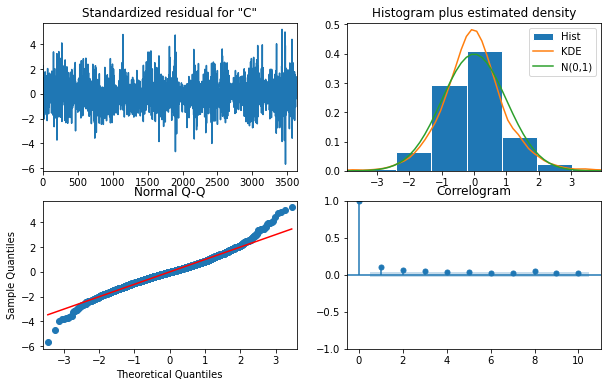

In [17]:
arima_res = model_fit_all
arima_res.plot_diagnostics(figsize=(10,6))
plt.show()

##### Standardized residual: Since there are no obvious patterns in the residuals,  it indicates a good model 
##### Histogram plus kde estimate: The histogram shows the measured distribution of the residuals while the orange line shows the KDE curve (smoothed version of the histogram). The green line shows a normal distribution. For a good model the orange line should be similar to the green line. 
##### Correlogram or ACF plot: 
#### Normal Q-Q: Most of the data points should lie on the straight line, indicating a normal distribution of the residuals. This is a good model.